# Fernandez *et al*. (2021)<br />**Bat *Saccopteryx bilineata***

**Paper:** Fernandez, A. A., Burchardt, L. S., Nagy, M., & Knörnschild, M. (2021). Babbling in a vocal learning bat resembles human infant babbling. *Science*, *373*(6557), 923–926. DOI: [10.1126/science.abf9279](https://doi.org/10.1126/science.abf9279)

**Dataset:** Fernandez, Ahana; Burchardt, Lara; Nagy, Martina; Knörnschild, Mirjam (2021), Babbling in a vocal learning bat resembles human infant babbling, Dryad, Dataset, DOI: [10.5061/dryad.1c59zw3vg](https://doi.org/10.5061/dryad.1c59zw3vg)

**Dataset license:** [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from rhythmplot import *

# Directory to all the raw data (included in this repository)
DATA_DIR = '../data/fernandez2021'
ORIGINAL_DATA_DIR = f'{DATA_DIR}/original-data'

# Function to save figures: you can easily toggle this on/off globally
savefig = get_figure_saver(group='fernandez2021', save_pdf=True, save_png=True)

## Preprocessing

The sheet 'IOI' from the excel file `Fernandez_et_al_2021_05_Rhythm_IOI_and_nPVI` is manually exported to `IOI.csv`, and this is further preprocessed below.


The normalized pairwise variability index (nPVI) is calculated to assess temporal variance in syllable trains and whether a syllable train is isochronous.	
The nPVI indicates the goodness of predictability from one IOI to the subsequent. The lower the nPVI, the more isochronous is the syllable train.	

For the method see: Burchardt L, Knörnschild M (2020) Comparison of methods for rhythm analysis of complex animals’ acoustic signals. PLoS Comput. Biol. 16, e1007755. doi:10.1371/journal.pcbi.1007755	

N = 30 syllable trains (6 trains per train type) produced by 14 different pups from two populations (Panama, Costa Rica)	
	
Column headings	
- `population`	Panama, Costa Rica
- `pup ID`	Identification numbers of pups
- `recording date`	year_month_day
- `syllable train type`	affiliative, aggressive, neutral, IC, UPS (see supplementary material for definitions)
- `label`	position of syllable in sequence
- `duration` [s]	duration of each syllable from start to end
- `start time`	time stamp of syllable onset
- `end time`	time stamp of syllable offset
- `IOI`	inter-onset-interval (time between the start of one syllable and the start of the next syllable)
- `nPVI`	normalized Pairwise Variability Index

In [2]:
columns = [
    'population',
    'pup_id', 
    'recording_date', 
    'syllable_train_type',
    'syllable_position', # was label 
    'syllable_duration',
    'syllable_start',
    'syllable_end',
    'syllable_ioi'
] 

In [3]:
df = pd.read_csv(f'{ORIGINAL_DATA_DIR}/IOI.csv', delimiter=';', decimal=",",  header=[0,1])
df.columns = columns
sequences = []
cur_seq = 0
for _, pos in df['syllable_position'].items():
    if pos == 1:
        cur_seq += 1
    sequences.append(cur_seq)
df['sequence'] = sequences
# df.to_csv(f'{DATA_DIR}/fernandez2021-data.csv', index=False)

In [4]:
intervals = []
for _, (pos, ioi) in df[['syllable_position', 'syllable_ioi']].iterrows():
    if pos == 1:
        intervals.append(np.nan)
    intervals.append(ioi)
intervals= np.array(intervals[1:])
# save_intervals(intervals, 'fernandez2021', 'fernandez2021')

## Plot

In [5]:
intervals = load_intervals('fernandez2021', 'fernandez2021')
df = pd.read_csv(f'{DATA_DIR}/fernandez2021-data.csv')

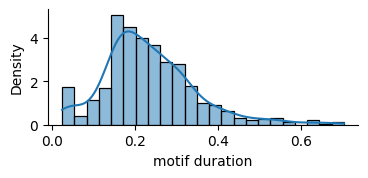

In [6]:
import seaborn as sns 
plt.figure(figsize=(4, 1.5))
motifs, duration = normalize(ngram_motifs(intervals, length=3))
sns.histplot(duration, kde=True, stat='density')
sns.despine()
plt.xlabel('motif duration');

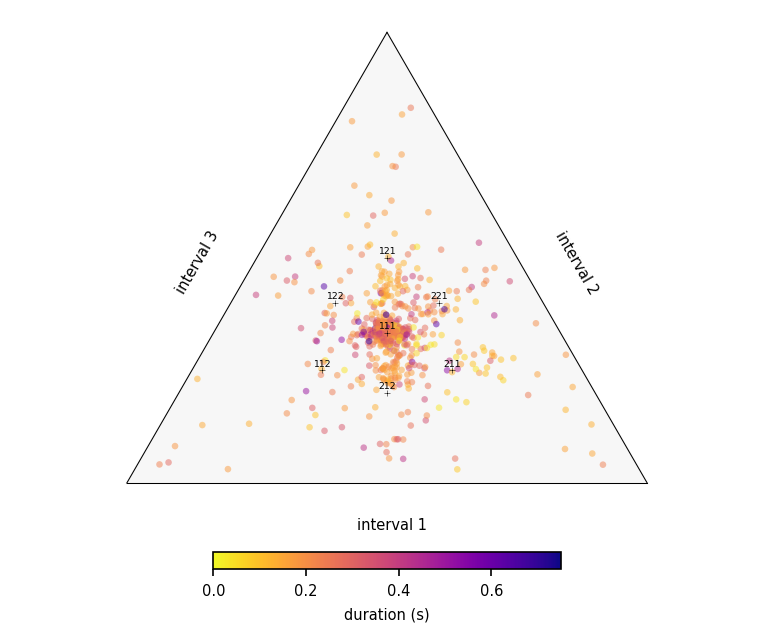

In [7]:
motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, 
    min_dur=0, max_dur=.75,
    scatter_kws=dict(s=10, alpha=.5), 
    ratio_kws=dict(factors=[1,2]))
savefig('motifs')

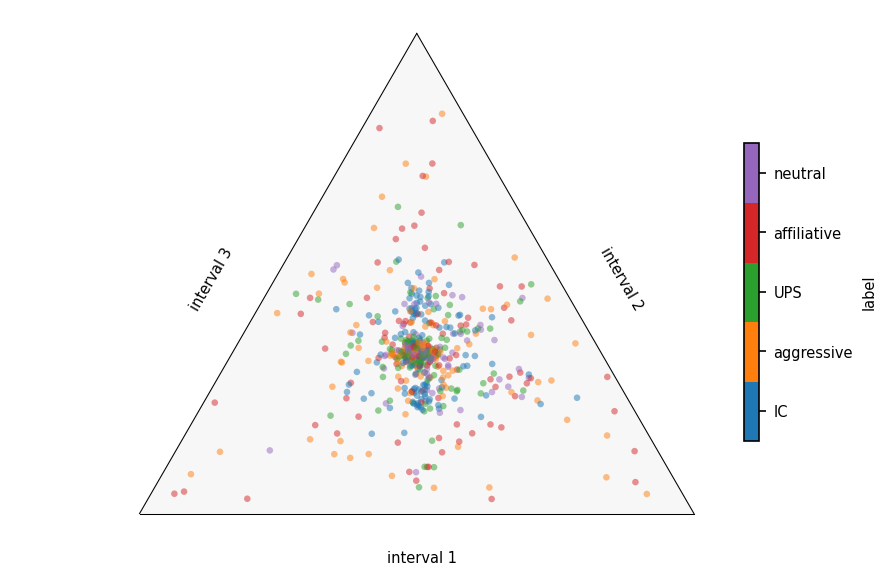

In [8]:
types = [ 'neutral', 'affiliative', 'UPS', 'aggressive', 'IC']
subset = separate_sequences(df[df['syllable_train_type'].isin(types)])

# Get rhythm motifs
intervals = subset['syllable_ioi'].values
motifs, duration = normalize(ngram_motifs(intervals, length=3))

# Determine labels
# Ignore columns where ioi is missing, but train type is not (i.e., last syll in a seq)
mismatch = subset['syllable_ioi'].isna() & (~subset['syllable_train_type'].isna())
train_types = subset[~mismatch]['syllable_train_type'].values
# All motifs in a sequence have the same type, so we just pick the first
labels = string_motifs(train_types, 3, aggregator=lambda motif: motif[0])

ternary_motif_plot(motifs, duration, labels=labels, 
    scatter_kws=dict(s=10, alpha=.5), 
    ratios=False, ratio_kws=dict(factors=[1,2]))

savefig('by-syllable-train-type')

In [9]:
for t in types:
    subset = df.query(f'syllable_train_type=="{t}"')
    ints = subset['syllable_ioi'].dropna().values
    print(t, nPVI(ints), orig_nPVI(ints))#MA(ints, 3), MA(ints, 4), MA(ints, 5))

neutral 22.29899318955039 22.29899318955039
affiliative 53.50744146807802 53.50744146807802
UPS 27.337568939777302 27.337568939777302
aggressive 43.295051262783275 43.295051262783275
IC 35.23519719049737 35.23519719049736


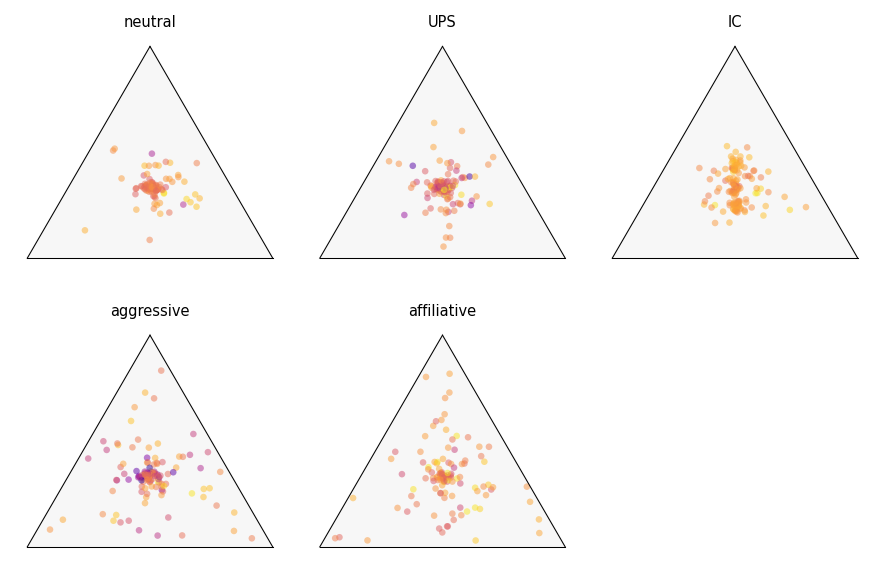

In [10]:
types = [
    'neutral', 
    'UPS', 
    'IC',
    'aggressive', 
    'affiliative' 
]
fig, axs = plt.subplots(2, 3, figsize=(6, 4), tight_layout=True)
for i, t in enumerate(types):
    subset = separate_sequences(df[df['syllable_train_type'] == t])

    # Get rhythm motifs
    intervals = subset['syllable_ioi'].values
    motifs, duration = normalize(ngram_motifs(intervals, length=3))

    # Determine labels
    # Ignore columns where ioi is missing, but train type is not (i.e., last syll in a seq)
    mismatch = subset['syllable_ioi'].isna() & (~subset['syllable_train_type'].isna())
    train_types = subset[~mismatch]['syllable_train_type'].values
    # All motifs in a sequence have the same type, so we just pick the first
    labels = string_motifs(train_types, 3, aggregator=lambda motif: motif[0])
    from matplotlib.colors import Normalize
    ternary_motif_plot(motifs, duration,
        min_dur=0, max_dur=.75,
        scatter_kws=dict(s=10, alpha=.5), 
        ratio_kws=dict(factors=[1,2]), 
        ratios=False,
        cbar=False,
        plot_kws=dict(labels=False), ax = axs.ravel()[i])
    axs.ravel()[i].set_title(t, fontsize=7)

axs[-1, -1].axis('off')
savefig('per-category')

### Combined

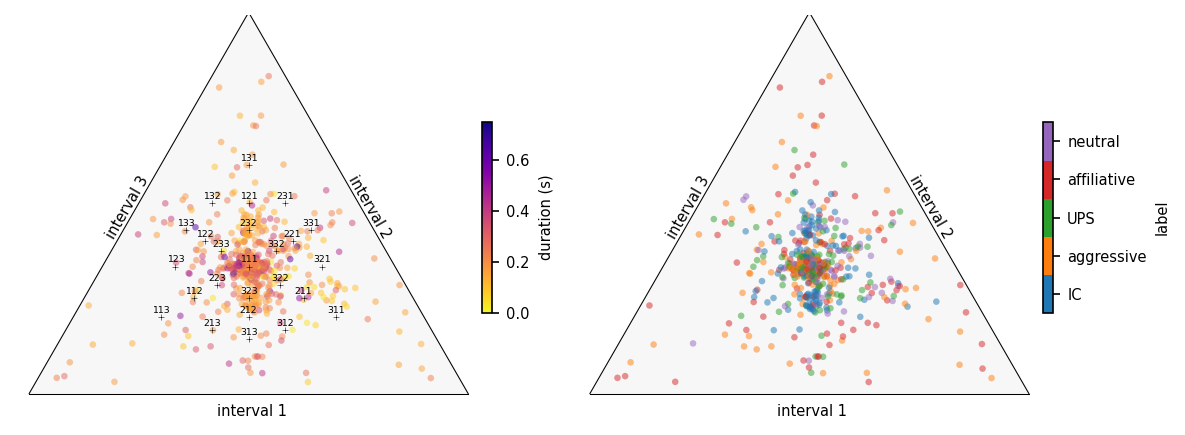

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

kws = dict(
    scatter_kws=dict(s=10, alpha=.5), min_dur=0, max_dur=0.75,
    cbar_kws=dict(orientation='vertical', pad=0, fraction=0.02)
)

# Plot, colored by duration
intervals = load_intervals('fernandez2021', 'fernandez2021')
motifs, duration = normalize(ngram_motifs(intervals, length=3))
ternary_motif_plot(motifs, duration, ax=ax1, **kws)

# Plot colored by category
types = [ 'neutral', 'affiliative', 'UPS', 'aggressive', 'IC']
subset = separate_sequences(df[df['syllable_train_type'].isin(types)])

# Get rhythm motifs
intervals = subset['syllable_ioi'].values
motifs, duration = normalize(ngram_motifs(intervals, length=3))

# Determine labels
# Ignore columns where ioi is missing, but train type is not (i.e., last syll in a seq)
mismatch = subset['syllable_ioi'].isna() & (~subset['syllable_train_type'].isna())
train_types = subset[~mismatch]['syllable_train_type'].values
# All motifs in a sequence have the same type, so we just pick the first
labels = string_motifs(train_types, 3, aggregator=lambda motif: motif[0])

ternary_motif_plot(motifs, duration, labels=labels,
    ratios=False, ratio_kws=dict(factors=[1,2]), ax=ax2, 
    **kws)

savefig('overview')